In [13]:
#author Tanmay
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanmaybhardwaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tanmaybhardwaj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tanmaybhardwaj/nltk_data...


True

In [2]:
import pandas as pd
from gensim import corpora, models
import gensim
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import CoherenceModel
import string
from wordcloud import WordCloud

In [7]:
# 1. Data Loading
data = pd.read_csv('foodstamp_submissions_allyears.csv')

0       t5_35fvq
1       t5_35fvq
2       t5_35fvq
3       t5_35fvq
4       t5_35fvq
          ...   
9004    t5_35fvq
9005    t5_35fvq
9006    t5_35fvq
9007    t5_35fvq
9008    t5_35fvq
Name: subreddit_id, Length: 9009, dtype: object


In [4]:
# 2. Data Filtering
# Filter for entries where 'California' is mentioned in the 'url', 'selftext', 'permalink', or 'title' columns
filtered_data = data[data['url'].str.contains('California', case=False, na=False) |
                     data['selftext'].str.contains('a', case=False, na=False) |
                     data['permalink'].str.contains('California', case=False, na=False) |
                     data['title'].str.contains('California', case=False, na=False)]

# Remove rows where 'selftext' is '[deleted]' or '[removed]'
filtered_data = filtered_data[~filtered_data['selftext'].str.contains('\[deleted\]', case=False, na=False)]
filtered_data = filtered_data[~filtered_data['selftext'].str.contains('\[removed\]', case=False, na=False)]

In [5]:
# 3. Data Preprocessing
# Handle NaN values and ensure the data type is string
filtered_data['selftext'] = filtered_data['selftext'].fillna('')
# Remove punctuation, numbers, and special characters
filtered_data['clean_selftext'] = filtered_data['selftext'].map(lambda x: re.sub('[,\.!?]', '', x))
filtered_data['clean_selftext'] = filtered_data['clean_selftext'].map(lambda x: re.sub('\d+', '', x))
# Convert to lowercase
filtered_data['clean_selftext'] = filtered_data['clean_selftext'].map(lambda x: x.lower())
print(filtered_data.shape)


(673, 41)


In [48]:
# Remove stop words and perform lemmatization

# Add custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = ["i'm","im", "i've", "im", "ive","hi","etc","would","want","get","Äôt","ampxb","thanks","i’m","got","th","irt","san"]
stop_words = stop_words.union(custom_stopwords)

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#stop = set(stopwords.words('english'))
#exclude = set(string.punctuation) 
#lemma = WordNetLemmatizer()
# def clean(doc):
#     stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
#     return normalized

clean_text = [clean(doc).split() for doc in filtered_data['clean_selftext']]

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(clean_text)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_text]

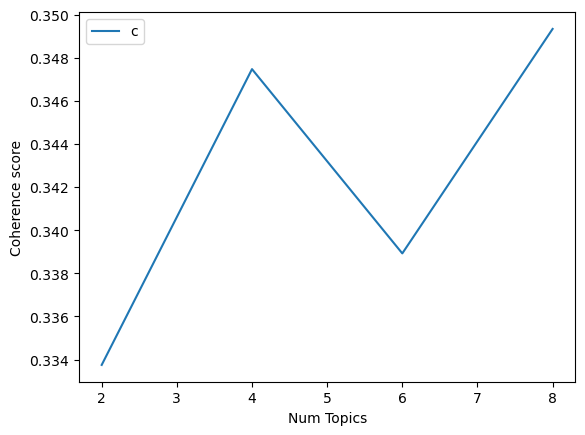

Num Topics = 2  has Coherence Value of 0.3338
Num Topics = 4  has Coherence Value of 0.3475
Num Topics = 6  has Coherence Value of 0.3389
Num Topics = 8  has Coherence Value of 0.3493


In [50]:
# #Deciding on what value of num_topic to choose for the most optimal results
#No Need to run this as, num_topics = 8 performed the best
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         # Build LDA model
#         model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
#         model_list.append(model)
        
#         # Compute Coherence Score using c_v
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=clean_text, start=2, limit=10, step=2)

# # Show graph
# import matplotlib.pyplot as plt

# limit=10; start=2; step=2;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [41]:
# 4. LDA Modeling
# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)


In [51]:
# 5. Result Interpretation
# Print the topics and the weights of words
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.013*"benefit" + 0.012*"case" + 0.010*"told" + 0.008*"california" + 0.008*"time" + 0.006*"say" + 0.006*"call" + 0.006*"submit" + 0.006*"received" + 0.005*"one"')
(1, '0.016*"county" + 0.015*"california" + 0.015*"benefit" + 0.015*"month" + 0.011*"calfresh" + 0.011*"food" + 0.009*"time" + 0.008*"know" + 0.008*"amount" + 0.008*"stamp"')
(2, '0.026*"california" + 0.025*"food" + 0.017*"ebt" + 0.013*"use" + 0.012*"stamp" + 0.011*"snap" + 0.011*"benefit" + 0.009*"live" + 0.009*"card" + 0.009*"state"')
(3, '0.020*"card" + 0.013*"month" + 0.011*"ebt" + 0.011*"benefit" + 0.011*"california" + 0.010*"call" + 0.009*"calfresh" + 0.008*"back" + 0.008*"received" + 0.008*"know"')
(4, '0.013*"california" + 0.010*"month" + 0.009*"food" + 0.009*"job" + 0.008*"need" + 0.008*"help" + 0.008*"time" + 0.007*"year" + 0.006*"case" + 0.006*"stamp"')
(5, '0.015*"california" + 0.011*"county" + 0.010*"calfresh" + 0.010*"anyone" + 0.009*"month" + 0.009*"benefit" + 0.008*"card" + 0.008*"know" + 0.008*"allotment"

In [52]:
topics = ldamodel.show_topics(num_topics=-1, num_words=10, formatted=False)

for topic_num, topic_words in topics:
    print(f"Topic {topic_num}:")
    words, weights = zip(*topic_words)  # Separates the words and their corresponding weights
    topic_str = ", ".join([f"{word} ({round(weight, 3)})" for word, weight in zip(words, weights)])
    print(f"Words: {topic_str}\n")

Topic 0:
Words: benefit (0.013000000268220901), case (0.012000000104308128), told (0.009999999776482582), california (0.00800000037997961), time (0.00800000037997961), say (0.006000000052154064), call (0.006000000052154064), submit (0.006000000052154064), received (0.006000000052154064), one (0.004999999888241291)

Topic 1:
Words: county (0.01600000075995922), california (0.014999999664723873), benefit (0.014999999664723873), month (0.014999999664723873), calfresh (0.010999999940395355), food (0.010999999940395355), time (0.008999999612569809), know (0.00800000037997961), amount (0.00800000037997961), stamp (0.00800000037997961)

Topic 2:
Words: california (0.026000000536441803), food (0.02500000037252903), ebt (0.017000000923871994), use (0.013000000268220901), stamp (0.012000000104308128), snap (0.010999999940395355), benefit (0.010999999940395355), live (0.008999999612569809), card (0.008999999612569809), state (0.008999999612569809)

Topic 3:
Words: card (0.019999999552965164), mon

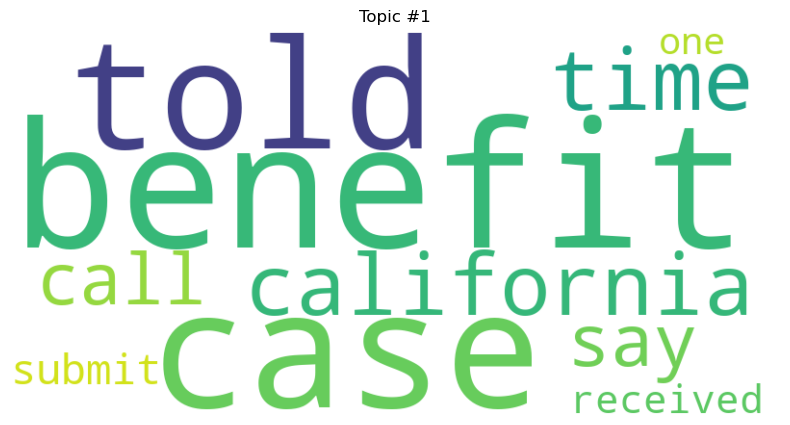

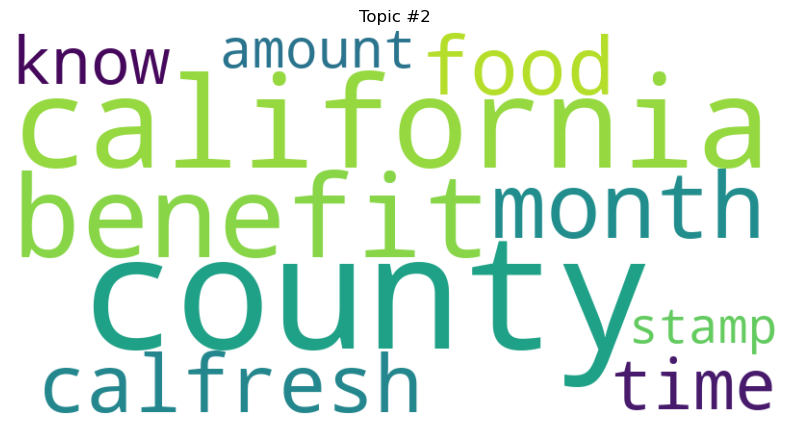

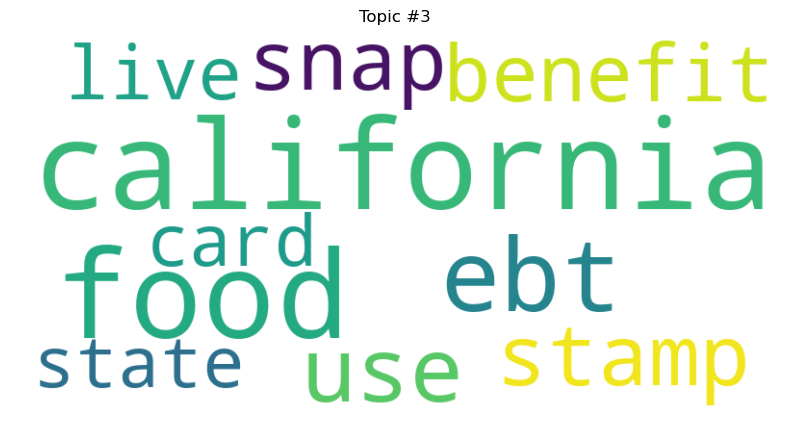

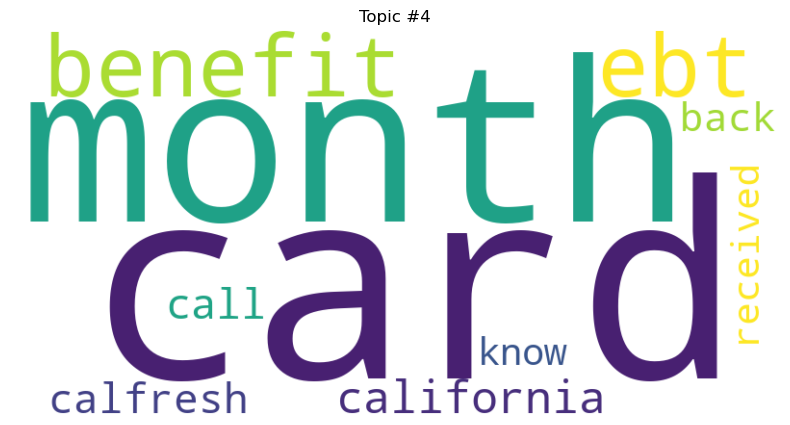

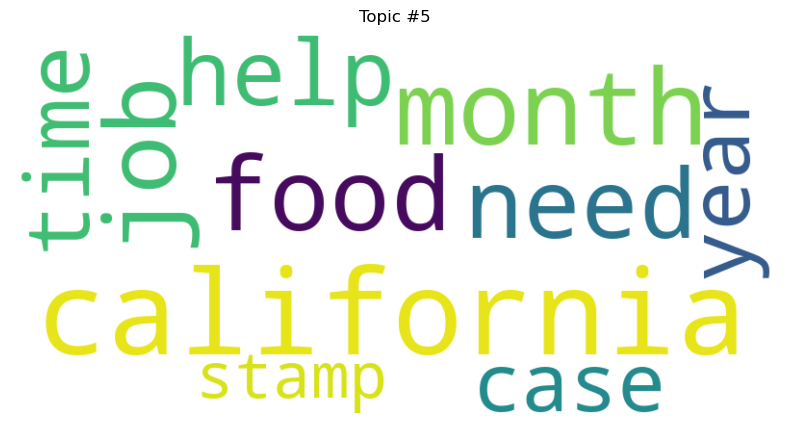

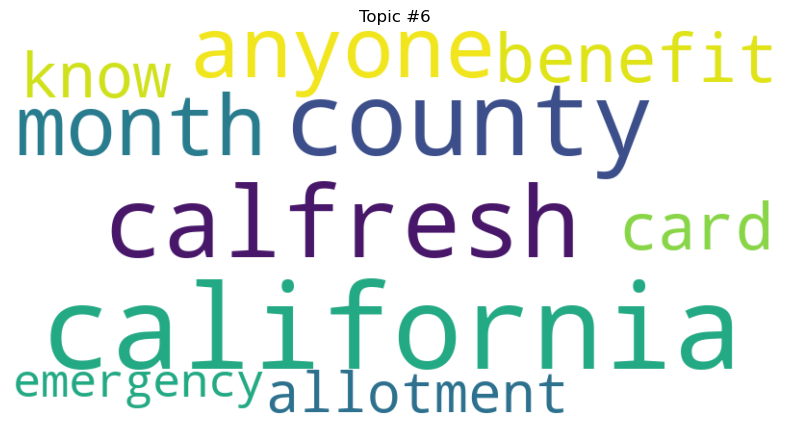

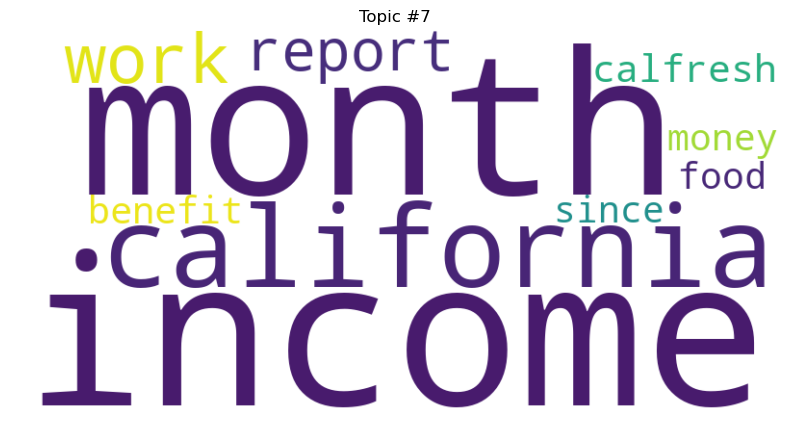

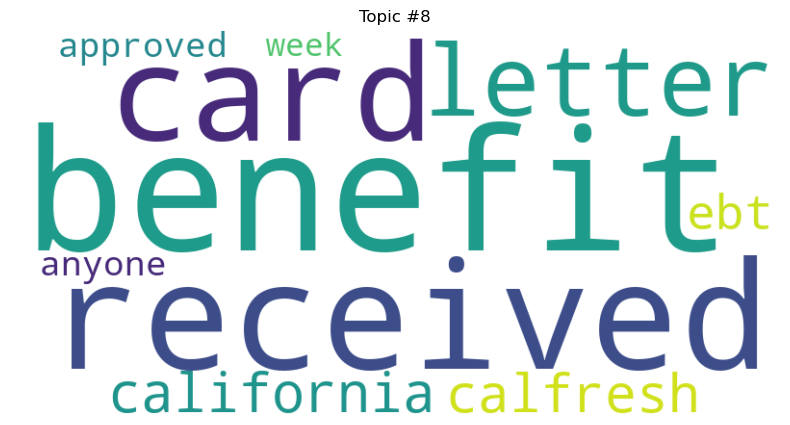

In [53]:
for topic_num, topic_words in topics:
    word_freq = dict(topic_words)
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic #{topic_num + 1}")
    plt.show()